In [466]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline
import seaborn as sns


import statsmodels.api as sm

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics

import re
from sklearn.metrics import explained_variance_score as evs
from sklearn.metrics import r2_score as r2


### Prediccion de precios de viviendas

In [467]:
data = pd.read_csv('ar_properties.csv')
data.head()

,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,...,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,property_type,operation_type
0,S0we3z3V2JpHUJreqQ2t/w==,Propiedad,2019-04-14,2019-06-14,2019-04-14,-34.943312,-54.929656,Uruguay,Maldonado,Punta del Este,...,NaN,1.0,45.0,40.0,13000.0,UYU,Mensual,Departamento - Roosevelt,Departamento,Alquiler
1,kMxcmAS8NvrynGBVbMOEaQ==,Propiedad,2019-04-14,2019-04-16,2019-04-14,-34.631810,-58.420599,Argentina,Capital Federal,Boedo,...,NaN,NaN,NaN,NaN,0.0,NaN,Mensual,PH - Boedo,PH,Venta
2,Ce3ojF+ZTOkB8d+LI9dpxg==,Propiedad,2019-04-14,9999-12-31,2019-04-14,NaN,NaN,Argentina,Bs.As. G.B.A. Zona Norte,NaN,...,NaN,1.0,200.0,NaN,NaN,NaN,NaN,Ituzaingo 1100 - $ 1 - Casa Alquiler,Casa,Alquiler
3,AUGpj3raGmOCiulSMGIBPA==,Propiedad,2019-04-14,9999-12-31,2019-04-14,-34.654705,-58.790894,Argentina,Bs.As. G.B.A. Zona Oeste,Moreno,...,NaN,2.0,460.0,100.0,NaN,NaN,Mensual,Dr. Vera 300 - Consulte precio - Casa en Venta,Casa,Venta
4,m+MwZmJl3OoxmfWcB//sBA==,Propiedad,2019-04-14,2019-07-09,2019-04-14,-34.654949,-58.787117,Argentina,Bs.As. G.B.A. Zona Oeste,Moreno,...,NaN,3.0,660.0,148.0,NaN,NaN,Mensual,L. N. Alem 2400 - Consulte precio - Casa en ...,Casa,Venta


In [468]:
## seleccion de propiedades en argentina
data_arg = data.loc[data['l1']=='Argentina']

In [469]:
data_arg.shape


(374977, 24)

In [470]:
data_arg.keys()

Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon',
       'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price', 'currency', 'price_period',
       'title', 'property_type', 'operation_type'],
      dtype='object')

In [471]:
data_arg['l2'].unique()

array(['Capital Federal', 'Bs.As. G.B.A. Zona Norte',
       'Bs.As. G.B.A. Zona Oeste', 'Santa Fe',
       'Buenos Aires Costa Atlántica', 'Río Negro', 'Córdoba', 'Tucumán',
       'Bs.As. G.B.A. Zona Sur', 'Neuquén', 'La Pampa', 'Corrientes',
       'Tierra Del Fuego', 'Salta', 'Buenos Aires Interior', 'Entre Ríos',
       'Misiones', 'Catamarca', 'Mendoza', 'San Juan', 'Chaco',
       'San Luis', 'Chubut', 'Jujuy', 'Santa Cruz', 'Santiago Del Estero',
       'La Rioja', 'Formosa'], dtype=object)

In [472]:
pd.set_option('display.max_rows',113)

group = data_arg.groupby(['l2','operation_type'])

group['property_type'].count()

l2                            operation_type   
Bs.As. G.B.A. Zona Norte      Alquiler             20933
                              Alquiler temporal     1246
                              Venta                49909
Bs.As. G.B.A. Zona Oeste      Alquiler              9054
                              Alquiler temporal       65
                              Venta                19457
Bs.As. G.B.A. Zona Sur        Alquiler              7865
                              Alquiler temporal       79
                              Venta                20136
Buenos Aires Costa Atlántica  Alquiler              7813
                              Alquiler temporal     1030
                              Venta                21806
Buenos Aires Interior         Alquiler              2153
                              Alquiler temporal       85
                              Venta                 6416
Capital Federal               Alquiler             32248
                              Alquiler t

In [473]:
data_capital = data_arg.loc[data_arg['l2']=='Capital Federal']

In [474]:
group = data_capital.groupby(['operation_type'])
group['property_type'].count()

operation_type
Alquiler             32248
Alquiler temporal    11208
Venta                80871
Name: property_type, dtype: int64

In [475]:
data_alquiler = data_capital.loc[data_capital['operation_type'].isin(['Alquiler','Alquiler temporal'])]

In [476]:
data_alquiler.groupby('property_type').count()

,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,...,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,operation_type
property_type,,,,,,,,,,,,,,,,,,,,,
Casa,729,729,729,729,729,699,699,729,729,718,...,362,415,661,610,632,684,606,551,729,729
Cochera,282,282,282,282,282,271,271,282,282,280,...,26,0,17,138,107,260,254,198,282,282
Departamento,31094,31094,31094,31094,31094,29574,29574,31094,31094,30982,...,28721,13358,29506,27108,26944,30890,30685,25044,31094,31094
Depósito,363,363,363,363,363,352,352,363,363,359,...,24,11,37,335,326,349,348,197,363,363
Local comercial,4629,4629,4629,4629,4629,4452,4452,4629,4629,4608,...,482,13,3231,4322,4173,4465,4326,3342,4629,4629
Lote,90,90,90,90,90,80,80,90,90,90,...,9,4,33,84,67,87,86,57,90,90
Oficina,4144,4144,4144,4144,4144,3955,3955,4144,4144,4107,...,1130,218,3242,3920,3948,4046,4022,2477,4144,4144
Otro,806,806,806,806,806,784,784,806,806,803,...,66,146,451,655,640,760,747,359,806,806
PH,1319,1319,1319,1319,1319,1269,1269,1319,1319,1312,...,1161,752,1198,1135,1163,1313,1302,1094,1319,1319


In [477]:
data_depto = data_alquiler.loc[data_alquiler['property_type'].isin(['Departamento'])]

In [478]:
data_depto.describe()

,lat,lon,l6,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,29574.000000,29574.000000,0.0,28721.000000,13358.000000,29506.000000,27108.000000,26944.000000,3.089000e+04
mean,-34.592777,-58.423396,NaN,2.225793,1.557494,1.291432,73.191862,66.522974,1.817184e+04
std,0.052152,0.052221,NaN,1.107123,0.823648,0.643478,585.879458,577.261794,3.402353e+04
min,-34.697266,-64.191827,NaN,1.000000,0.000000,1.000000,0.000000,-4.000000,0.000000e+00
25%,-34.605969,-58.445847,NaN,1.000000,1.000000,1.000000,38.000000,35.000000,1.050000e+04
50%,-34.592899,-58.420690,NaN,2.000000,1.000000,1.000000,50.000000,45.000000,1.590000e+04
75%,-34.579230,-58.395213,NaN,3.000000,2.000000,1.000000,74.000000,68.000000,2.300000e+04
max,-27.469213,-58.356673,NaN,25.000000,11.000000,14.000000,92135.000000,92135.000000,3.409000e+06


Cantidad de Filas: 31094 Cantidad de Columnas: 24

                tipos de dato  cantidad de nulos  porcentaje_nulos
l6                    float64              31094            100.00
l5                     object              31094            100.00
l4                     object              29136             93.70
bedrooms              float64              17736             57.04
price_period           object               6050             19.46
surface_covered       float64               4150             13.35
surface_total         float64               3986             12.82
rooms                 float64               2373              7.63
bathrooms             float64               1588              5.11
lat                   float64               1520              4.89
lon                   float64               1520              4.89
currency               object                409              1.32
price                 float64                204              0.66
l3         

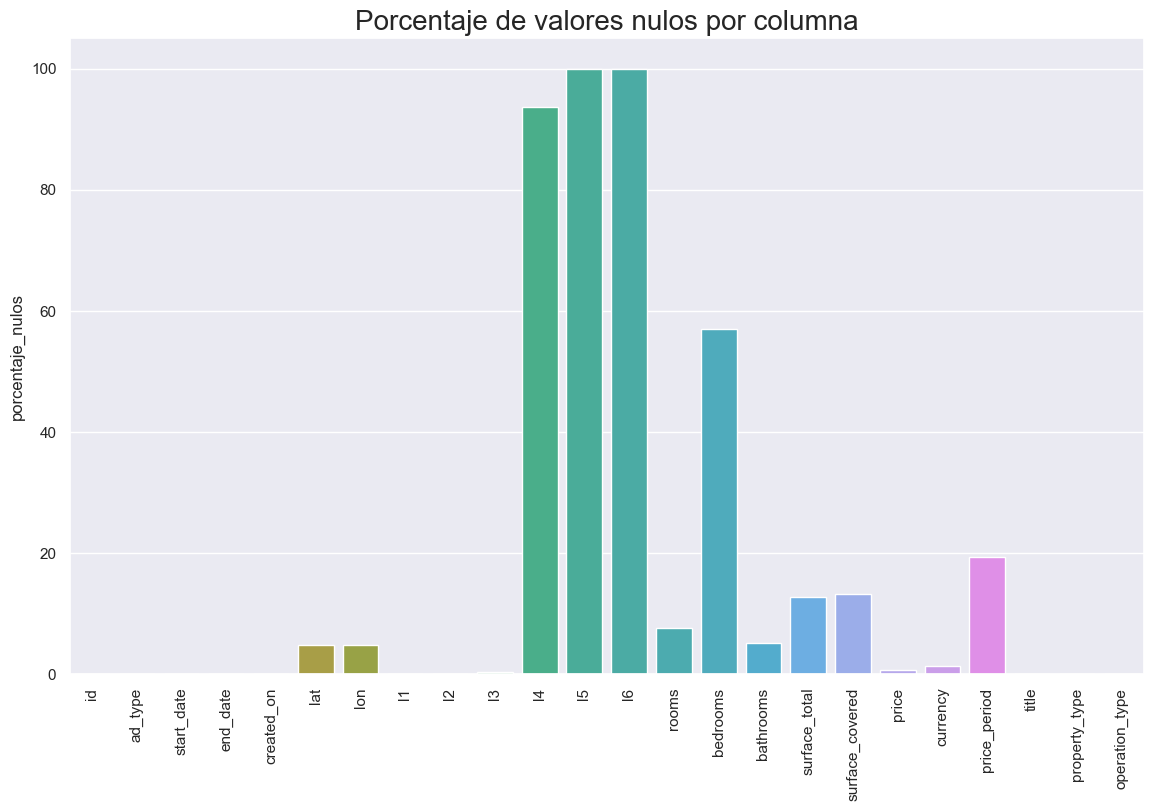

In [479]:
print(f'Cantidad de Filas: {data_depto.shape[0]} Cantidad de Columnas: {data_depto.shape[1]}')
print("""""")
nulos = data_depto.isnull().sum()
tipos = data_depto.dtypes
show_me = pd.DataFrame ()
show_me['tipos de dato'] =tipos
show_me['cantidad de nulos'] = nulos
show_me['porcentaje_nulos'] = round(nulos*100/data_depto.shape[0],2)
#show_me = show_me.rename(columns={'Index':'Caracteristica'})
print(show_me.sort_values('cantidad de nulos', ascending= False))

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x=show_me.index, y='porcentaje_nulos', data=show_me)
plt.title("Porcentaje de valores nulos por columna", size=20)
plt.xticks(rotation=90)
plt.tight_layout()

In [480]:
# Las columnas L4,L5,L6 y bedrooms tienen un faltante de mas del 50 % de los datos. Se decide eliminarlas. 
columnas_drop=['l4','l5','l6','bedrooms']
data_depto = data_depto.drop(columnas_drop, axis=1)

In [481]:
# elijo quedarme solo con aquellas propiedades que tengan precio y currency
data_depto.dropna(subset=['price', 'currency'])

,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,property_type,operation_type
125,sLUQCgOMH5F3LhfiRS1H9Q==,Propiedad,2019-04-14,2019-04-27,2019-04-14,-34.631766,-58.463209,Argentina,Capital Federal,Flores,2.0,1.0,47.0,NaN,30000.0,ARS,Mensual,"Flores - Juan Bautista Alberdi 2500, 47m2, 2 A...",Departamento,Alquiler temporal
128,D646CphpllBaWstfX+aD0Q==,Propiedad,2019-04-14,2019-04-27,2019-04-14,-34.577635,-58.436660,Argentina,Capital Federal,Palermo,2.0,1.0,47.0,NaN,30000.0,ARS,Mensual,Palermo Soho - Arevalo y Soler,Departamento,Alquiler temporal
129,CPkuGQQ0hOAgL4Ea1qhtIw==,Propiedad,2019-04-14,2019-04-27,2019-04-14,-34.566178,-58.452158,Argentina,Capital Federal,Belgrano,2.0,1.0,74.0,NaN,33000.0,ARS,Mensual,"BELGRANO - VIRREY DEL PINO Y AV CABILDO, 2AMB-...",Departamento,Alquiler temporal
130,xYyxNMcht0ZYBofoTnGHEQ==,Propiedad,2019-04-14,2019-04-23,2019-04-14,-34.566115,-58.452068,Argentina,Capital Federal,Belgrano,2.0,1.0,84.0,NaN,35000.0,ARS,Mensual,"Belgrano - Virrey del Pino y Av Cabildo, 2amb,...",Departamento,Alquiler temporal
131,u3ErzCcBUJ6J5WUGYtWdPw==,Propiedad,2019-04-14,2019-04-27,2019-04-14,-34.555978,-58.461422,Argentina,Capital Federal,Belgrano,1.0,1.0,41.0,36.0,12000.0,ARS,Mensual,Departamento - Belgrano,Departamento,Alquiler
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388104,5yhX04ycq983Rp5Maq0ocg==,Propiedad,2019-03-24,2019-08-18,2019-03-24,-34.548223,-58.455886,Argentina,Capital Federal,Nuñez,4.0,3.0,215.0,205.0,5500.0,USD,Mensual,Oportunidad! 4 Amb C/dep Torre Chateau Liberta...,Departamento,Alquiler
388114,iNVEY4Aj8ZZetfQLXbnzhg==,Propiedad,2019-03-24,2019-03-26,2019-03-24,-34.565807,-58.436932,Argentina,Capital Federal,Palermo,NaN,1.0,NaN,NaN,12500.0,USD,Mensual,Departamento - Las Cañitas,Departamento,Alquiler
388607,60heRtoJ2COPvg44P/CEqg==,Propiedad,2019-03-24,2019-06-17,2019-03-24,-34.602537,-58.363781,Argentina,Capital Federal,Puerto Madero,3.0,2.0,149.0,134.0,1500.0,USD,NaN,alquiler amoblado! Espectacular departamento. ...,Departamento,Alquiler
388774,dlFMQw1Ea2BGp/vPUx5HDw==,Propiedad,2019-03-24,2019-06-23,2019-03-24,-34.587792,-58.386385,Argentina,Capital Federal,Recoleta,5.0,3.0,188.0,172.0,3000.0,USD,NaN,Piso de 3 dormitorios / Dependencia / Cochera ...,Departamento,Alquiler


In [482]:
data_depto.describe()

,lat,lon,rooms,bathrooms,surface_total,surface_covered,price
count,29574.000000,29574.000000,28721.000000,29506.000000,27108.000000,26944.000000,3.089000e+04
mean,-34.592777,-58.423396,2.225793,1.291432,73.191862,66.522974,1.817184e+04
std,0.052152,0.052221,1.107123,0.643478,585.879458,577.261794,3.402353e+04
min,-34.697266,-64.191827,1.000000,1.000000,0.000000,-4.000000,0.000000e+00
25%,-34.605969,-58.445847,1.000000,1.000000,38.000000,35.000000,1.050000e+04
50%,-34.592899,-58.420690,2.000000,1.000000,50.000000,45.000000,1.590000e+04
75%,-34.579230,-58.395213,3.000000,1.000000,74.000000,68.000000,2.300000e+04
max,-27.469213,-58.356673,25.000000,14.000000,92135.000000,92135.000000,3.409000e+06


In [483]:
## Retiro valores extremos
cuarto_p_rooms = data_depto['rooms'].quantile(0.995)
primer_p_rooms = data_depto['rooms'].quantile(0.005)

cuarto_baño = data_depto['bathrooms'].quantile(0.9995)
primer_baño = data_depto['bathrooms'].quantile(0.0005)





In [484]:
data_depto = data_depto[(data_depto['rooms']>primer_p_rooms)&(data_depto['rooms']<cuarto_p_rooms)]

In [485]:
data_depto = data_depto[(data_depto['bathrooms']>primer_baño)&(data_depto['bathrooms']<cuarto_baño)]

In [486]:
data_depto

,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,property_type,operation_type
134,JPBIR+IWLd/HE2rdDRjiuw==,Propiedad,2019-04-14,2019-07-03,2019-04-14,-34.567532,-58.454731,Argentina,Capital Federal,Belgrano,2.0,2.0,82.0,72.0,25000.0,ARS,NaN,Virrey Del Pino 2600 1° - $ 25.000 - Departa...,Departamento,Alquiler
136,FAZR22Bnp7warZIDvql1Gw==,Propiedad,2019-04-14,2019-04-27,2019-04-14,-34.587802,-58.399895,Argentina,Capital Federal,Recoleta,4.0,2.0,75.0,NaN,42000.0,ARS,Mensual,Recoleta - Pacheco de Melo 2500,Departamento,Alquiler temporal
137,dCYI593OP/4yfZW4o1Yuig==,Propiedad,2019-04-14,2019-05-04,2019-04-14,-34.596693,-58.407461,Argentina,Capital Federal,Recoleta,3.0,2.0,82.0,NaN,50000.0,ARS,Mensual,Recoleta - Thomas de ANCHORENA 1100,Departamento,Alquiler temporal
202,t1xP7b2Zhvs6FNxUyMXh0Q==,Propiedad,2019-04-14,2019-06-23,2019-04-14,-34.609558,-58.362674,Argentina,Capital Federal,Puerto Madero,2.0,2.0,73.0,63.0,50000.0,ARS,NaN,Excelente vista. Dos ambientes. Cochera. Ameni...,Departamento,Alquiler
222,5B6EliZZ+Zmkat+zdbxamA==,Propiedad,2019-04-14,2019-04-27,2019-04-14,-34.596265,-58.442387,Argentina,Capital Federal,Villa Crespo,3.0,2.0,72.0,66.0,20000.0,ARS,Mensual,DEPARTAMENTO EN ALQUILER,Departamento,Alquiler
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387769,AK2hgIiOOkh2PLX9A/xikA==,Propiedad,2019-03-24,2019-04-01,2019-03-24,-34.603771,-58.381587,Argentina,Capital Federal,Caballito,4.0,2.0,125.0,112.0,25000.0,ARS,Mensual,Alquiler - Guayaquil 500,Departamento,Alquiler
388104,5yhX04ycq983Rp5Maq0ocg==,Propiedad,2019-03-24,2019-08-18,2019-03-24,-34.548223,-58.455886,Argentina,Capital Federal,Nuñez,4.0,3.0,215.0,205.0,5500.0,USD,Mensual,Oportunidad! 4 Amb C/dep Torre Chateau Liberta...,Departamento,Alquiler
388607,60heRtoJ2COPvg44P/CEqg==,Propiedad,2019-03-24,2019-06-17,2019-03-24,-34.602537,-58.363781,Argentina,Capital Federal,Puerto Madero,3.0,2.0,149.0,134.0,1500.0,USD,NaN,alquiler amoblado! Espectacular departamento. ...,Departamento,Alquiler
388774,dlFMQw1Ea2BGp/vPUx5HDw==,Propiedad,2019-03-24,2019-06-23,2019-03-24,-34.587792,-58.386385,Argentina,Capital Federal,Recoleta,5.0,3.0,188.0,172.0,3000.0,USD,NaN,Piso de 3 dormitorios / Dependencia / Cochera ...,Departamento,Alquiler


In [487]:
data_depto.currency.value_counts()

ARS    3429
USD    2381
Name: currency, dtype: int64

In [488]:
data_depto.operation_type.value_counts()

Alquiler             4513
Alquiler temporal    1344
Name: operation_type, dtype: int64

In [489]:
# llevo todos los valores a una misma moneda
data_depto['precio'] = data_depto.apply(lambda row: (row['price']
                                               if row['currency']=='ARS'
                                               else row['price']*360),
                                   axis=1)


In [490]:
data_depto

,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,...,bathrooms,surface_total,surface_covered,price,currency,price_period,title,property_type,operation_type,precio
134,JPBIR+IWLd/HE2rdDRjiuw==,Propiedad,2019-04-14,2019-07-03,2019-04-14,-34.567532,-58.454731,Argentina,Capital Federal,Belgrano,...,2.0,82.0,72.0,25000.0,ARS,NaN,Virrey Del Pino 2600 1° - $ 25.000 - Departa...,Departamento,Alquiler,25000.0
136,FAZR22Bnp7warZIDvql1Gw==,Propiedad,2019-04-14,2019-04-27,2019-04-14,-34.587802,-58.399895,Argentina,Capital Federal,Recoleta,...,2.0,75.0,NaN,42000.0,ARS,Mensual,Recoleta - Pacheco de Melo 2500,Departamento,Alquiler temporal,42000.0
137,dCYI593OP/4yfZW4o1Yuig==,Propiedad,2019-04-14,2019-05-04,2019-04-14,-34.596693,-58.407461,Argentina,Capital Federal,Recoleta,...,2.0,82.0,NaN,50000.0,ARS,Mensual,Recoleta - Thomas de ANCHORENA 1100,Departamento,Alquiler temporal,50000.0
202,t1xP7b2Zhvs6FNxUyMXh0Q==,Propiedad,2019-04-14,2019-06-23,2019-04-14,-34.609558,-58.362674,Argentina,Capital Federal,Puerto Madero,...,2.0,73.0,63.0,50000.0,ARS,NaN,Excelente vista. Dos ambientes. Cochera. Ameni...,Departamento,Alquiler,50000.0
222,5B6EliZZ+Zmkat+zdbxamA==,Propiedad,2019-04-14,2019-04-27,2019-04-14,-34.596265,-58.442387,Argentina,Capital Federal,Villa Crespo,...,2.0,72.0,66.0,20000.0,ARS,Mensual,DEPARTAMENTO EN ALQUILER,Departamento,Alquiler,20000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387769,AK2hgIiOOkh2PLX9A/xikA==,Propiedad,2019-03-24,2019-04-01,2019-03-24,-34.603771,-58.381587,Argentina,Capital Federal,Caballito,...,2.0,125.0,112.0,25000.0,ARS,Mensual,Alquiler - Guayaquil 500,Departamento,Alquiler,25000.0
388104,5yhX04ycq983Rp5Maq0ocg==,Propiedad,2019-03-24,2019-08-18,2019-03-24,-34.548223,-58.455886,Argentina,Capital Federal,Nuñez,...,3.0,215.0,205.0,5500.0,USD,Mensual,Oportunidad! 4 Amb C/dep Torre Chateau Liberta...,Departamento,Alquiler,1980000.0
388607,60heRtoJ2COPvg44P/CEqg==,Propiedad,2019-03-24,2019-06-17,2019-03-24,-34.602537,-58.363781,Argentina,Capital Federal,Puerto Madero,...,2.0,149.0,134.0,1500.0,USD,NaN,alquiler amoblado! Espectacular departamento. ...,Departamento,Alquiler,540000.0
388774,dlFMQw1Ea2BGp/vPUx5HDw==,Propiedad,2019-03-24,2019-06-23,2019-03-24,-34.587792,-58.386385,Argentina,Capital Federal,Recoleta,...,3.0,188.0,172.0,3000.0,USD,NaN,Piso de 3 dormitorios / Dependencia / Cochera ...,Departamento,Alquiler,1080000.0


In [491]:
#busco algunos atributos
lista_atributos=['jardin','cochera','seguridad',"parrilla",'pileta','terraza','subte','lavadero',"quincho", "balcon", "gimnasio"]

def description_search(lista_atributos):
    for i in lista_atributos:
        import re
        atributo = i
        regex_atributo=re.compile(i, re.IGNORECASE)
        atributos_results=data_depto.title.apply(lambda x : x if x is np.NaN else regex_atributo.search(x))
        print(i,atributos_results.notnull().sum())
        data_depto[i]= atributos_results.notnull().astype(int) #agrega columna, diciendo si tiene tal atributo

description_search(lista_atributos)

jardin 28
cochera 1282
seguridad 33
parrilla 72
pileta 38
terraza 228
subte 9
lavadero 15
quincho 3
balcon 132
gimnasio 0


In [492]:
data_depto

,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,...,cochera,seguridad,parrilla,pileta,terraza,subte,lavadero,quincho,balcon,gimnasio
134,JPBIR+IWLd/HE2rdDRjiuw==,Propiedad,2019-04-14,2019-07-03,2019-04-14,-34.567532,-58.454731,Argentina,Capital Federal,Belgrano,...,0,0,0,0,0,0,0,0,0,0
136,FAZR22Bnp7warZIDvql1Gw==,Propiedad,2019-04-14,2019-04-27,2019-04-14,-34.587802,-58.399895,Argentina,Capital Federal,Recoleta,...,0,0,0,0,0,0,0,0,0,0
137,dCYI593OP/4yfZW4o1Yuig==,Propiedad,2019-04-14,2019-05-04,2019-04-14,-34.596693,-58.407461,Argentina,Capital Federal,Recoleta,...,0,0,0,0,0,0,0,0,0,0
202,t1xP7b2Zhvs6FNxUyMXh0Q==,Propiedad,2019-04-14,2019-06-23,2019-04-14,-34.609558,-58.362674,Argentina,Capital Federal,Puerto Madero,...,1,0,0,0,0,0,0,0,0,0
222,5B6EliZZ+Zmkat+zdbxamA==,Propiedad,2019-04-14,2019-04-27,2019-04-14,-34.596265,-58.442387,Argentina,Capital Federal,Villa Crespo,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387769,AK2hgIiOOkh2PLX9A/xikA==,Propiedad,2019-03-24,2019-04-01,2019-03-24,-34.603771,-58.381587,Argentina,Capital Federal,Caballito,...,0,0,0,0,0,0,0,0,0,0
388104,5yhX04ycq983Rp5Maq0ocg==,Propiedad,2019-03-24,2019-08-18,2019-03-24,-34.548223,-58.455886,Argentina,Capital Federal,Nuñez,...,1,0,0,0,0,0,0,0,0,0
388607,60heRtoJ2COPvg44P/CEqg==,Propiedad,2019-03-24,2019-06-17,2019-03-24,-34.602537,-58.363781,Argentina,Capital Federal,Puerto Madero,...,1,0,0,0,1,0,0,0,0,0
388774,dlFMQw1Ea2BGp/vPUx5HDw==,Propiedad,2019-03-24,2019-06-23,2019-03-24,-34.587792,-58.386385,Argentina,Capital Federal,Recoleta,...,1,0,0,0,0,0,0,0,0,0


In [493]:
# Segrego l3 en dummies y operation_type

In [494]:
dummies = pd.get_dummies(data_depto['l3'],drop_first = True)

In [495]:
data_depto = pd.concat([data_depto,dummies],axis=1)

In [496]:
dummy = pd.get_dummies(data_depto['operation_type'],drop_first = True)

In [497]:
data_depto = pd.concat([data_depto,dummy],axis = 1)

In [498]:
data_depto

,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,...,Villa General Mitre,Villa Lugano,Villa Luro,Villa Ortuzar,Villa Pueyrredón,Villa Real,Villa Santa Rita,Villa Urquiza,Villa del Parque,Alquiler temporal
134,JPBIR+IWLd/HE2rdDRjiuw==,Propiedad,2019-04-14,2019-07-03,2019-04-14,-34.567532,-58.454731,Argentina,Capital Federal,Belgrano,...,0,0,0,0,0,0,0,0,0,0
136,FAZR22Bnp7warZIDvql1Gw==,Propiedad,2019-04-14,2019-04-27,2019-04-14,-34.587802,-58.399895,Argentina,Capital Federal,Recoleta,...,0,0,0,0,0,0,0,0,0,1
137,dCYI593OP/4yfZW4o1Yuig==,Propiedad,2019-04-14,2019-05-04,2019-04-14,-34.596693,-58.407461,Argentina,Capital Federal,Recoleta,...,0,0,0,0,0,0,0,0,0,1
202,t1xP7b2Zhvs6FNxUyMXh0Q==,Propiedad,2019-04-14,2019-06-23,2019-04-14,-34.609558,-58.362674,Argentina,Capital Federal,Puerto Madero,...,0,0,0,0,0,0,0,0,0,0
222,5B6EliZZ+Zmkat+zdbxamA==,Propiedad,2019-04-14,2019-04-27,2019-04-14,-34.596265,-58.442387,Argentina,Capital Federal,Villa Crespo,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387769,AK2hgIiOOkh2PLX9A/xikA==,Propiedad,2019-03-24,2019-04-01,2019-03-24,-34.603771,-58.381587,Argentina,Capital Federal,Caballito,...,0,0,0,0,0,0,0,0,0,0
388104,5yhX04ycq983Rp5Maq0ocg==,Propiedad,2019-03-24,2019-08-18,2019-03-24,-34.548223,-58.455886,Argentina,Capital Federal,Nuñez,...,0,0,0,0,0,0,0,0,0,0
388607,60heRtoJ2COPvg44P/CEqg==,Propiedad,2019-03-24,2019-06-17,2019-03-24,-34.602537,-58.363781,Argentina,Capital Federal,Puerto Madero,...,0,0,0,0,0,0,0,0,0,0
388774,dlFMQw1Ea2BGp/vPUx5HDw==,Propiedad,2019-03-24,2019-06-23,2019-03-24,-34.587792,-58.386385,Argentina,Capital Federal,Recoleta,...,0,0,0,0,0,0,0,0,0,0


In [499]:
data_depto.columns

Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon',
       'l1', 'l2', 'l3', 'rooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'currency', 'price_period', 'title',
       'property_type', 'operation_type', 'precio', 'jardin', 'cochera',
       'seguridad', 'parrilla', 'pileta', 'terraza', 'subte', 'lavadero',
       'quincho', 'balcon', 'gimnasio', 'Agronomía', 'Almagro', 'Balvanera',
       'Barracas', 'Barrio Norte', 'Belgrano', 'Boca', 'Boedo', 'Caballito',
       'Catalinas', 'Centro / Microcentro', 'Chacarita', 'Coghlan',
       'Colegiales', 'Congreso', 'Constitución', 'Flores', 'Floresta',
       'Las Cañitas', 'Liniers', 'Mataderos', 'Monserrat', 'Monte Castro',
       'Nuñez', 'Once', 'Palermo', 'Parque Centenario', 'Parque Chacabuco',
       'Parque Chas', 'Parque Patricios', 'Paternal', 'Pompeya',
       'Puerto Madero', 'Recoleta', 'Retiro', 'Saavedra', 'San Cristobal',
       'San Nicolás', 'San Telmo', 'Tribunales', 'Velez

In [500]:
columnas_drop=['id', 'ad_type', 'start_date', 'end_date', 'created_on','l1','l2','l3','price','price_period', 'title','currency',
               'operation_type','property_type', 'operation_type']
data_depto = data_depto.drop(columnas_drop, axis=1)

In [501]:
data_depto

,lat,lon,rooms,bathrooms,surface_total,surface_covered,precio,jardin,cochera,seguridad,...,Villa General Mitre,Villa Lugano,Villa Luro,Villa Ortuzar,Villa Pueyrredón,Villa Real,Villa Santa Rita,Villa Urquiza,Villa del Parque,Alquiler temporal
134,-34.567532,-58.454731,2.0,2.0,82.0,72.0,25000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
136,-34.587802,-58.399895,4.0,2.0,75.0,NaN,42000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
137,-34.596693,-58.407461,3.0,2.0,82.0,NaN,50000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
202,-34.609558,-58.362674,2.0,2.0,73.0,63.0,50000.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
222,-34.596265,-58.442387,3.0,2.0,72.0,66.0,20000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387769,-34.603771,-58.381587,4.0,2.0,125.0,112.0,25000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
388104,-34.548223,-58.455886,4.0,3.0,215.0,205.0,1980000.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
388607,-34.602537,-58.363781,3.0,2.0,149.0,134.0,540000.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
388774,-34.587792,-58.386385,5.0,3.0,188.0,172.0,1080000.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [502]:
data_clean = data_depto.dropna()

In [503]:
data_clean

,lat,lon,rooms,bathrooms,surface_total,surface_covered,precio,jardin,cochera,seguridad,...,Villa General Mitre,Villa Lugano,Villa Luro,Villa Ortuzar,Villa Pueyrredón,Villa Real,Villa Santa Rita,Villa Urquiza,Villa del Parque,Alquiler temporal
134,-34.567532,-58.454731,2.0,2.0,82.0,72.0,25000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
202,-34.609558,-58.362674,2.0,2.0,73.0,63.0,50000.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
222,-34.596265,-58.442387,3.0,2.0,72.0,66.0,20000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
223,-34.623036,-58.394638,3.0,2.0,92.0,88.0,18500.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
233,-34.591242,-58.402556,4.0,2.0,85.0,76.0,28000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387769,-34.603771,-58.381587,4.0,2.0,125.0,112.0,25000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
388104,-34.548223,-58.455886,4.0,3.0,215.0,205.0,1980000.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
388607,-34.602537,-58.363781,3.0,2.0,149.0,134.0,540000.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
388774,-34.587792,-58.386385,5.0,3.0,188.0,172.0,1080000.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Modelos de predicion de precio

##### extraccion de un conjunto aleatorios de datos para posterior verificacion del modelo

In [504]:
muestra = data_clean.sample(150)

In [505]:
data_clean = data_clean.drop(muestra.index)

In [506]:
data_clean.columns

Index(['lat', 'lon', 'rooms', 'bathrooms', 'surface_total', 'surface_covered',
       'precio', 'jardin', 'cochera', 'seguridad', 'parrilla', 'pileta',
       'terraza', 'subte', 'lavadero', 'quincho', 'balcon', 'gimnasio',
       'Agronomía', 'Almagro', 'Balvanera', 'Barracas', 'Barrio Norte',
       'Belgrano', 'Boca', 'Boedo', 'Caballito', 'Catalinas',
       'Centro / Microcentro', 'Chacarita', 'Coghlan', 'Colegiales',
       'Congreso', 'Constitución', 'Flores', 'Floresta', 'Las Cañitas',
       'Liniers', 'Mataderos', 'Monserrat', 'Monte Castro', 'Nuñez', 'Once',
       'Palermo', 'Parque Centenario', 'Parque Chacabuco', 'Parque Chas',
       'Parque Patricios', 'Paternal', 'Pompeya', 'Puerto Madero', 'Recoleta',
       'Retiro', 'Saavedra', 'San Cristobal', 'San Nicolás', 'San Telmo',
       'Tribunales', 'Velez Sarsfield', 'Versalles', 'Villa Crespo',
       'Villa Devoto', 'Villa General Mitre', 'Villa Lugano', 'Villa Luro',
       'Villa Ortuzar', 'Villa Pueyrredón', 'Villa R

In [507]:
X = data_clean.drop(['lat', 'lon','precio'],axis=1)

In [508]:
scaler = StandardScaler()

In [509]:
scaler.fit(X)
X_std = scaler.transform(X)

In [510]:
y = data_clean['precio']

### Modelo de Regresion de minimos cuadrados

In [511]:
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 precio   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     21.18
Date:                Tue, 04 Apr 2023   Prob (F-statistic):          2.85e-215
Time:                        14:37:55   Log-Likelihood:                -66588.
No. Observations:                4491   AIC:                         1.333e+05
Df Residuals:                    4423   BIC:                         1.337e+05
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1.191e+06 

In [512]:
### Da un R square bajo.

### Utilizo un modelo lineal sin modelizacion

In [513]:
X = data_clean.drop(['lat', 'lon','precio'],axis=1)
y = data_clean['precio']

In [514]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [515]:
ols = LinearRegression()
ols.fit(X_train, y_train)
ols_yhat = ols.predict(X_test)

In [516]:
ols.score(X_train,y_train) 

0.2274659420128995

In [517]:
evs(y_test,ols_yhat)

0.3155933827359534

In [518]:
r2(y_test,ols_yhat)

0.3128720332350534

Pruebo con la muestra de 150 viviendas

In [519]:
muestra

,lat,lon,rooms,bathrooms,surface_total,surface_covered,precio,jardin,cochera,seguridad,...,Villa General Mitre,Villa Lugano,Villa Luro,Villa Ortuzar,Villa Pueyrredón,Villa Real,Villa Santa Rita,Villa Urquiza,Villa del Parque,Alquiler temporal
316012,-34.592661,-58.392841,3.0,2.0,75.0,70.0,648000.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
343658,-34.621275,-58.361481,4.0,2.0,140.0,130.0,900000.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
266325,-34.625178,-58.472870,4.0,2.0,99.0,91.0,17000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
250524,-34.587065,-58.388078,3.0,2.0,78.0,78.0,594000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
163446,-34.616149,-58.375942,4.0,2.0,120.0,120.0,42000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379634,-34.607665,-58.414617,3.0,2.0,90.0,80.0,29500.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
380026,-34.573864,-58.440661,4.0,2.0,98.0,74.0,30000.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
257140,-34.582173,-58.432043,3.0,2.0,85.0,85.0,612000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53443,-34.620763,-58.430250,3.0,2.0,67.0,60.0,22000.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [520]:
muestra_y = muestra['precio']

In [521]:
muestra_x = muestra.drop(['lat', 'lon','precio'],axis=1)

In [522]:
muestra_y_pred = ols.predict(muestra_x)

In [523]:
muestra_y_serie = pd.Series(muestra_y_pred)
df_1 = pd.DataFrame(data=muestra_y, columns=['precio'])
df_1=df_1.reset_index(drop=True)
df_2=pd.DataFrame(data=muestra_y_serie, columns=['precio_prediccion'])
tabla=pd.concat([df_1, df_2], axis=1)

<AxesSubplot:xlabel='precio', ylabel='precio_prediccion'>

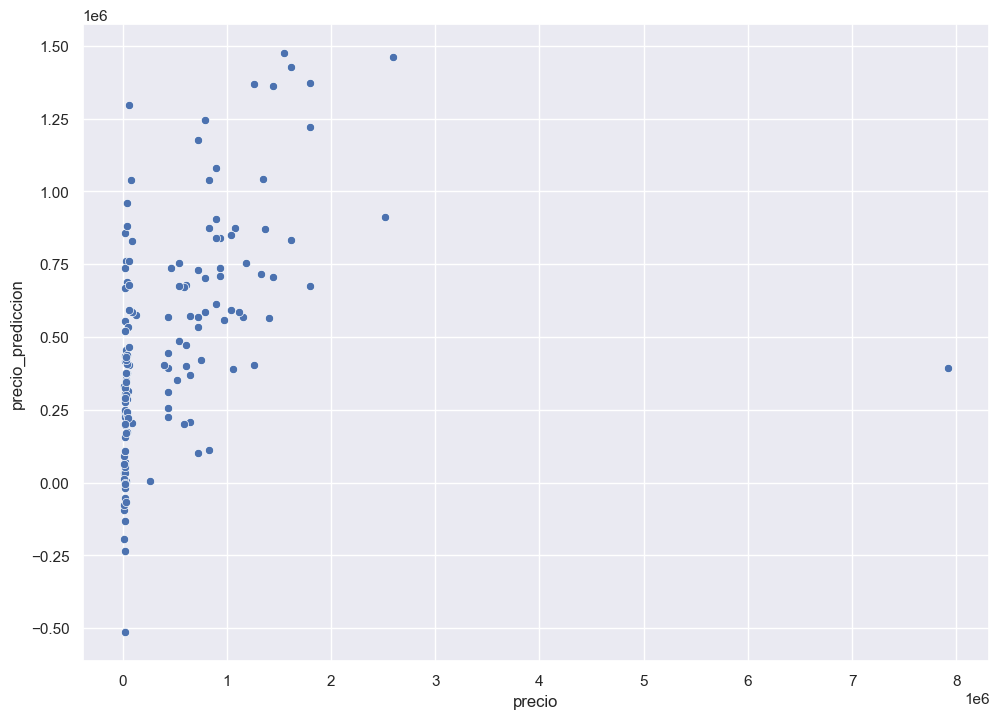

In [ ]:
sns.scatterplot(data=tabla, x='precio', y='precio_prediccion')

In [ ]:
data_depto

,lat,lon,rooms,bathrooms,surface_total,surface_covered,precio,jardin,cochera,seguridad,...,Villa General Mitre,Villa Lugano,Villa Luro,Villa Ortuzar,Villa Pueyrredón,Villa Real,Villa Santa Rita,Villa Urquiza,Villa del Parque,Alquiler temporal
134,-34.567532,-58.454731,2.0,2.0,82.0,72.0,25000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
136,-34.587802,-58.399895,4.0,2.0,75.0,NaN,42000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
137,-34.596693,-58.407461,3.0,2.0,82.0,NaN,50000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
202,-34.609558,-58.362674,2.0,2.0,73.0,63.0,50000.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
222,-34.596265,-58.442387,3.0,2.0,72.0,66.0,20000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387769,-34.603771,-58.381587,4.0,2.0,125.0,112.0,25000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
388104,-34.548223,-58.455886,4.0,3.0,215.0,205.0,1980000.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
388607,-34.602537,-58.363781,3.0,2.0,149.0,134.0,540000.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
388774,-34.587792,-58.386385,5.0,3.0,188.0,172.0,1080000.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [527]:
depto = data_alquiler.loc[data_alquiler['property_type'].isin(['Departamento'])]

In [528]:
dummies = pd.get_dummies(depto['l3'],drop_first = True)

In [529]:
depto = pd.concat([depto,dummies],axis=1)

In [530]:
dummy = pd.get_dummies(depto['operation_type'],drop_first = True)

In [531]:
depto = pd.concat([depto,dummy],axis=1)

In [532]:
currency = pd.get_dummies(depto['currency'],drop_first = True)

In [533]:
depto =  pd.concat([depto,currency],axis=1)

In [534]:
depto.columns

Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon',
       'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price', 'currency', 'price_period',
       'title', 'property_type', 'operation_type', 'Agronomía', 'Almagro',
       'Balvanera', 'Barracas', 'Barrio Norte', 'Belgrano', 'Boca', 'Boedo',
       'Caballito', 'Catalinas', 'Centro / Microcentro', 'Chacarita',
       'Coghlan', 'Colegiales', 'Congreso', 'Constitución', 'Flores',
       'Floresta', 'Las Cañitas', 'Liniers', 'Mataderos', 'Monserrat',
       'Monte Castro', 'Nuñez', 'Once', 'Palermo', 'Parque Avellaneda',
       'Parque Centenario', 'Parque Chacabuco', 'Parque Chas',
       'Parque Patricios', 'Paternal', 'Pompeya', 'Puerto Madero', 'Recoleta',
       'Retiro', 'Saavedra', 'San Cristobal', 'San Nicolás', 'San Telmo',
       'Tribunales', 'Velez Sarsfield', 'Versalles', 'Villa Crespo',
       'Villa Devoto', 'Villa General Mitre',

In [535]:
depto = depto.drop(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon',
       'l1', 'l2', 'l3','l4', 'l5', 'l6','bedrooms','price_period', 'title', 'property_type', 'operation_type','currency'],axis=1)

In [536]:
depto = depto.dropna()

In [537]:
X = depto.drop(['price'],axis=1)
y = depto['price']

In [538]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [539]:
ols = LinearRegression()
ols.fit(X_train, y_train)
ols_yhat = ols.predict(X_test)

In [540]:
ols.score(X_train,y_train) 

0.5138374298813577

In [541]:
ols_yhat 

array([19866.26681723, 22962.27939958, 33996.71205069, ...,
       35890.47633804, 21576.49212222, -1478.39146406])

In [542]:
y_test

174347    25000.0
152885    19000.0
219347    28000.0
248572    15000.0
174602    20000.0
           ...   
294340    17000.0
307427    20000.0
285580    30000.0
51783     14500.0
385020     1500.0
Name: price, Length: 4408, dtype: float64

In [549]:
y_pred = pd.Series(ols_yhat)

y_serie=pd.DataFrame(data=y_pred, columns=['precio_prediccion'])


In [550]:
y_serie

,precio_prediccion
0,19866.266817
1,22962.279400
2,33996.712051
3,8775.951834
4,35763.327949
...,...
4403,22712.825575
4404,26194.704337
4405,35890.476338
4406,21576.492122


In [555]:
test = pd.DataFrame(data = y_test.values, columns = ['precio'])

In [556]:
test

,precio
0,25000.0
1,19000.0
2,28000.0
3,15000.0
4,20000.0
...,...
4403,17000.0
4404,20000.0
4405,30000.0
4406,14500.0


In [559]:
tabla_2 = pd.concat([y_serie, test], axis=1)

<AxesSubplot:xlabel='precio', ylabel='precio_prediccion'>

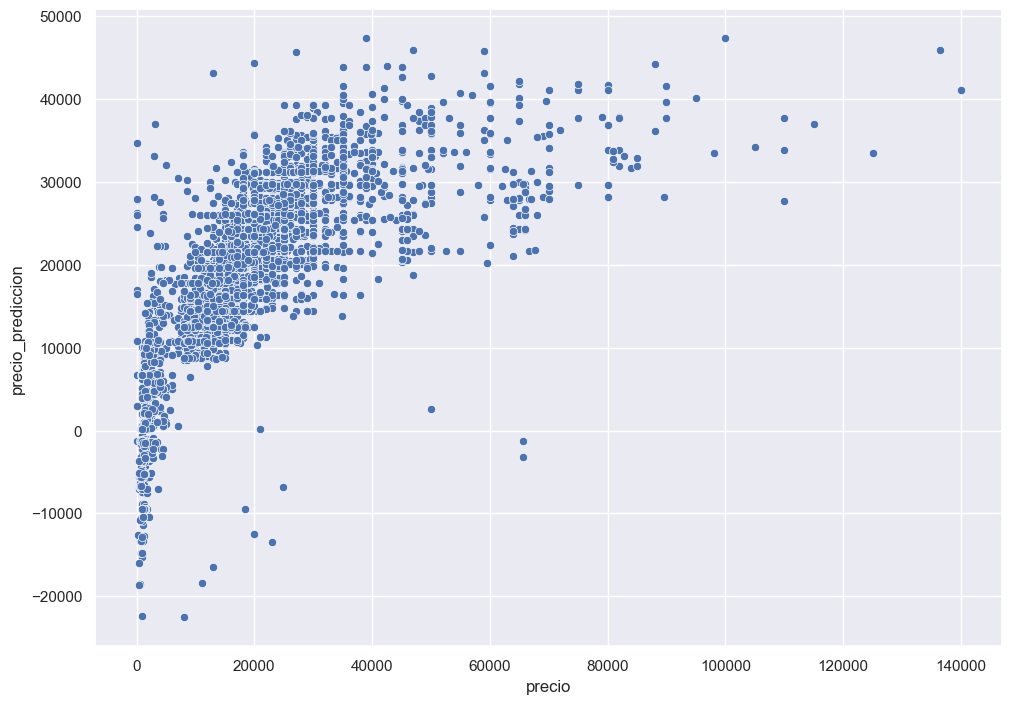

In [561]:
sns.scatterplot(data=tabla_2, x='precio', y='precio_prediccion')